### Prepare Data



#### imports and setup:

So rodar estes dois pip's se nao tiver ainda feito:

In [1]:
#pip install roboflow

In [2]:
#pip install imagehash

In [2]:
#%pip install -q torch

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
#import libraries:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import shutil
import glob
import io
import os
import pathlib
import PIL
from PIL import Image
from PIL import UnidentifiedImageError
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import yaml
import random
import pandas as pd
import hashlib
from collections import Counter, defaultdict
from pathlib import Path
from roboflow import Roboflow
import imagehash
from sklearn.model_selection import train_test_split
import albumentations as A
from torch.utils.data import DataLoader
from albumentations.pytorch import ToTensorV2
import cv2, torch
from torch.utils.data import Dataset, DataLoader


Import Dataset:

Este dataset, downloaded em formato YOLOv8
contém imagens e TXT annotations and YAML config onde se encontram as respetivas labels e label id.

YOLOv8 is a state-of-the-art object detection and image segmentation model


 https://universe.roboflow.com/car-damage-detection-cardd/car-damage-severity-detection-cardd

In [4]:
#from roboflow with yolov8
#if already have the dataset, no need to run this:
rf = Roboflow(api_key="YHTjnmxe3lRU4B3THhhe")
project = rf.workspace("car-damage-detection-cardd").project("car-damage-severity-detection-cardd")
version = project.version(3)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Car-Damage-Severity-Detection/CarDD-3 in yolov8:: 100%|██████████| 4012/4012 [00:02<00:00, 1557.33it/s]


In [5]:
#paths and dir:
BASE_path = Path("./Car-Damage-Severity-Detection/CarDD-3")
BASE_dir = "./Car-Damage-Severity-Detection/CarDD-3"

train_path = pathlib.Path("./Car-Damage-Severity-Detection/CarDD-3/train")
train_labels_dir = "./Car-Damage-Severity-Detection/CarDD-3/train/labels"

valid_path = pathlib.Path("./Car-Damage-Severity-Detection/CarDD-3/valid")
valid_labels_dir = "./Car-Damage-Severity-Detection/CarDD-3/valid/labels"

test_path = pathlib.Path("./Car-Damage-Severity-Detection/CarDD-3/test")
test_labels_dir = "./Car-Damage-Severity-Detection/CarDD-3/test/labels"

---
#### Data Content:

DEsta vez, como cada imagem pode ter mais do que uma label, em vez das classes estarem em pastas, estao todas no ficheiro yaml

Para saber quantas imagens e labels tem cada set (train, valid, test):


In [6]:
print("Conteúdo de CarDD-3:", os.listdir(BASE_dir))

for sub in os.listdir(BASE_dir):
    subpath = os.path.join(BASE_dir, sub)
    if os.path.isdir(subpath):
        print(f" - {sub}:", os.listdir(subpath))

print("\n")

#Contagem de imagens e labels:
for split in ["train", "valid", "test"]:
  img_dir = os.path.join(BASE_dir, split, "images")
  lbl_dir = os.path.join(BASE_dir, split, "labels")

  n_images = len([f for f in os.listdir(img_dir) if f.lower().endswith(".jpg")])
  n_labels = len([f for f in os.listdir(lbl_dir) if f.lower().endswith(".txt")])

  print(f"{split:5s}: {n_images:4d} imagens, {n_labels:4d} labels")

Conteúdo de CarDD-3: ['data.yaml', 'README.dataset.txt', 'README.roboflow.txt', 'test', 'train', 'valid']
 - test: ['images', 'labels']
 - train: ['images', 'labels']
 - valid: ['images', 'labels']


train: 1395 imagens, 1395 labels
valid:  401 imagens,  401 labels
test :  204 imagens,  204 labels


In [7]:
#quantas labels ha:
class_ids = set()
for fname in os.listdir(train_labels_dir):
    if not fname.endswith('.txt'): continue
    with open(os.path.join(train_labels_dir, fname)) as f:
        for line in f:
            cid = int(line.split()[0])
            class_ids.add(cid)

print('IDs de classes:', sorted(class_ids))
print(f'Total de classes: {len(class_ids)}')

IDs de classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Total de classes: 11


Há 11 classes. nas imagens tem os id's e o yaml indica qual o correspondente nome


In [8]:
with open('./Car-Damage-Severity-Detection/CarDD-3/data.yaml') as f:
    data = yaml.safe_load(f)

print("Nomes de classe (ID --> nome):")
for idx, name in enumerate(data['names']):
    print(idx, name)

Nomes de classe (ID --> nome):
0 car-part-crack
1 detachment
2 flat-tire
3 glass-crack
4 lamp-crack
5 minor-deformation
6 moderate-deformation
7 paint-chips
8 scratches
9 severe-deformation
10 side-mirror-crack


---
#### Vizualise the dataset:

In [9]:
#labels
with open("./Car-Damage-Severity-Detection/CarDD-3/data.yaml") as f:
    data = yaml.safe_load(f)
class_names = data["names"]




*   train set





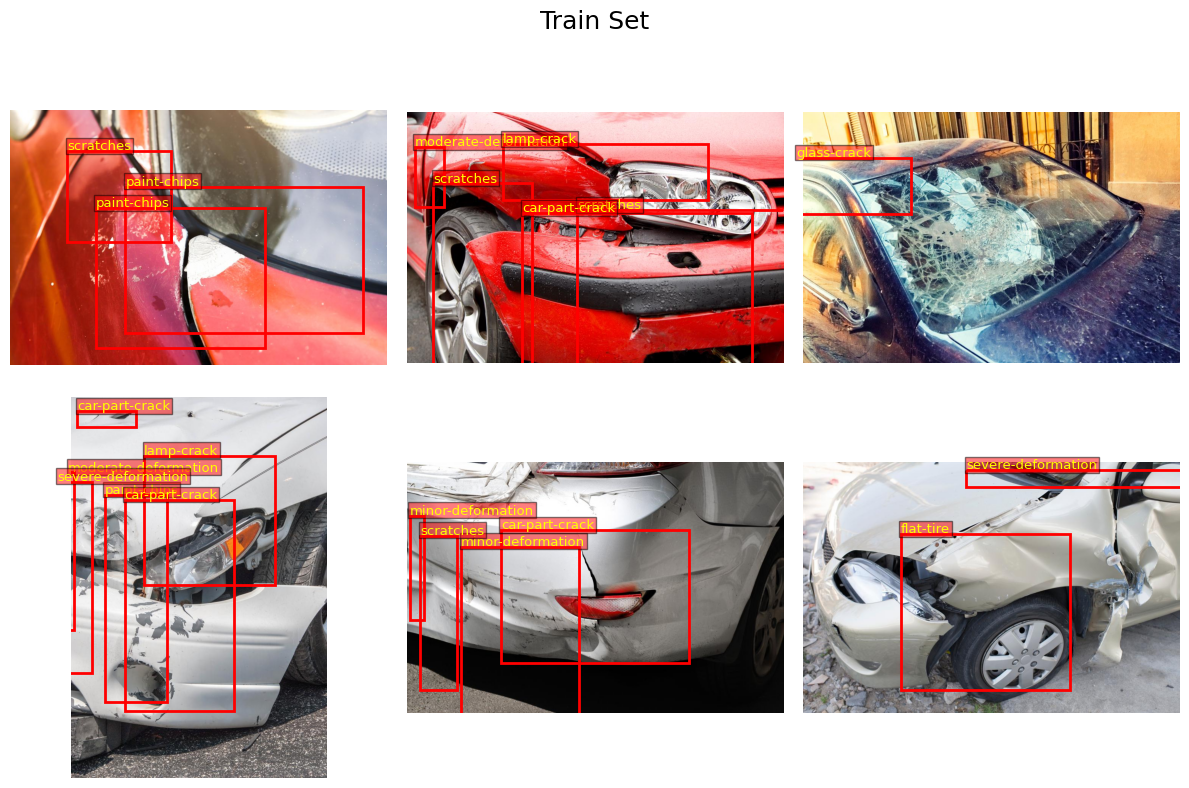

In [10]:
#ver o train set
split = "train"
img_dir = f"./Car-Damage-Severity-Detection/CarDD-3/{split}/images"
lbl_dir = f"./Car-Damage-Severity-Detection/CarDD-3/{split}/labels"


imgs = [f for f in os.listdir(img_dir) if f.lower().endswith(".jpg")]
sample = random.sample(imgs, 6)
fig = plt.figure(figsize=(12, 8))
fig.suptitle("Train Set", fontsize=18)
#fig.subplots_adjust(top=0.3)
for i, fname in enumerate(sample, 1):
    img = Image.open(os.path.join(img_dir, fname))
    w, h = img.size

    boxes = []
    with open(os.path.join(lbl_dir, fname.replace(".jpg", ".txt"))) as f_lbl:
        for line in f_lbl:
            vals = line.split()
            cid = int(vals[0])
            x_center, y_center, bw, bh = map(float, vals[1:5])
            x1 = (x_center - bw/2) * w
            y1 = (y_center - bh/2) * h
            boxes.append((cid, x1, y1, bw*w, bh*h))

    ax = fig.add_subplot(2, 3, i)
    ax.imshow(img); ax.axis("off")

    for cid, x1, y1, bw_px, bh_px in boxes:
        rect = patches.Rectangle((x1, y1), bw_px, bh_px,
                                 linewidth=2, edgecolor="red", facecolor="none")
        ax.add_patch(rect)
        ax.text(x1, y1-5, class_names[cid],
                fontsize=9.5, color="yellow",
                bbox=dict(facecolor="red", alpha=0.5, pad=1))

#plt.tight_layout()
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()



*   validation set


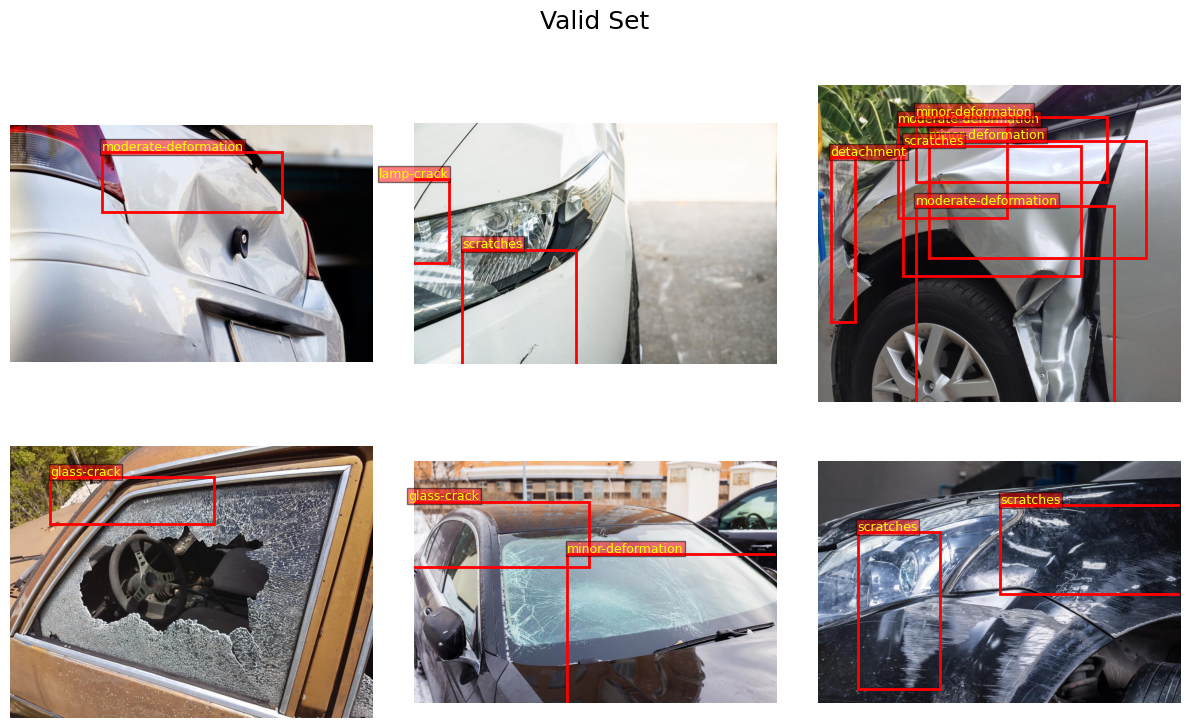

In [11]:
#ver o valid set
split = "valid"
img_dir = f"./Car-Damage-Severity-Detection/CarDD-3/{split}/images"
lbl_dir = f"./Car-Damage-Severity-Detection/CarDD-3/{split}/labels"


imgs = [f for f in os.listdir(img_dir) if f.lower().endswith(".jpg")]
sample = random.sample(imgs, 6)
fig = plt.figure(figsize=(12, 8))
fig.suptitle("Valid Set", fontsize=18)
#fig.subplots_adjust(top=0.3)
for i, fname in enumerate(sample, 1):
    img = Image.open(os.path.join(img_dir, fname))
    w, h = img.size

    boxes = []
    with open(os.path.join(lbl_dir, fname.replace(".jpg", ".txt"))) as f_lbl:
        for line in f_lbl:
            vals = line.split()
            cid = int(vals[0])
            x_center, y_center, bw, bh = map(float, vals[1:5])
            x1 = (x_center - bw/2) * w
            y1 = (y_center - bh/2) * h
            boxes.append((cid, x1, y1, bw*w, bh*h))

    ax = fig.add_subplot(2, 3, i)
    ax.imshow(img); ax.axis("off")

    for cid, x1, y1, bw_px, bh_px in boxes:
        rect = patches.Rectangle((x1, y1), bw_px, bh_px,
                                 linewidth=2, edgecolor="red", facecolor="none")
        ax.add_patch(rect)
        ax.text(x1, y1-5, class_names[cid],
                fontsize=9, color="yellow",
                bbox=dict(facecolor="red", alpha=0.5, pad=1))

plt.tight_layout()
#plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

---
#### Sanity-checks:

* Leakage:

In [12]:
TRAIN_GLOB = "./Car-Damage-Severity-Detection/CarDD-3/train/**/*.jpg"
VAL_GLOB   = "./Car-Damage-Severity-Detection/CarDD-3/valid/**/*.jpg"
PHASH_THRESH = 5

def sha1(path: str) -> str:
  with open(path, "rb") as f:
    return hashlib.sha1(f.read()).hexdigest()
def phash(path: str) -> imagehash.ImageHash:
  return imagehash.phash(Image.open(path))

def find_duplicates(train_glob: str, val_glob: str, phash_thresh: int = 5):
  train_paths = glob.glob(train_glob, recursive=True)
  val_paths   = glob.glob(val_glob, recursive=True)
  print(f"→ TRAIN imgs: {len(train_paths)}")
  print(f"→  VAL  imgs: {len(val_paths)}")

  train_sha = {sha1(p): p for p in train_paths}
  val_sha   = {sha1(p): p for p in val_paths}
  exact = [(train_sha[h], val_sha[h]) for h in train_sha if h in val_sha]
  print(f"Duplicados EXACTOS: {len(exact)}")
  for a, b in exact[:3]:
    print("  •", a, "\n   ", b)

  val_ph = {phash(p): p for p in val_paths}
  close = []
  for p in train_paths:
    h = phash(p)
    for hv in val_ph:
      if h - hv <= phash_thresh:
        close.append((p, val_ph[hv]))
  print(f"Duplicados PARECIDOS (≤{phash_thresh} bits): {len(close)}")
  for a, b in close[:3]:
    print("  •", a, "\n   ", b)

  return exact, close

if __name__ == "__main__":
    leaks_exact, leaks_close = find_duplicates(TRAIN_GLOB, VAL_GLOB, PHASH_THRESH)
    if leaks_exact or leaks_close:
        print("\n⚠️ Detetado leakage")
    else:
        print("\n✅ Sem leakage.")


→ TRAIN imgs: 1395
→  VAL  imgs: 401
Duplicados EXACTOS: 0
Duplicados PARECIDOS (≤5 bits): 0

✅ Sem leakage.


* Data corruption:

In [13]:
splits = ["train", "valid", "test"]

def find_corrupted(split):
  corrupted = []
  img_dir = BASE_path / split / "images"
  for img_path in img_dir.glob("*.jpg"):
    try:
      with Image.open(img_path) as img:
        img.verify()
    except (UnidentifiedImageError, OSError) as e:
      corrupted.append((img_path.name, str(e)))
  return corrupted

#to know if there is any image corrupted for each split:
for split in splits:
    bad = find_corrupted(split)
    if not bad:
        print(f"{split:5s}: nenhuma imagem corrompida encontrada ✅")
    else:
        print(f"{split:5s}: {len(bad)} imagens corrompidas ❌")
        for name, err in bad:
            print(f"   • {name:<40s} → {err}")

train: nenhuma imagem corrompida encontrada ✅
valid: nenhuma imagem corrompida encontrada ✅
test : nenhuma imagem corrompida encontrada ✅


* Label balance

In [14]:
with open(BASE_path / "data.yaml") as f:
    class_names = yaml.safe_load(f)["names"]

rows = []
for split in ["train", "valid", "test"]:
    counts = {name: 0 for name in class_names}
    for lbl_file in (BASE_path / split / "labels").glob("*.txt"):
        for line in open(lbl_file):
            parts = line.split()
            if parts:
                cid = int(parts[0])
                counts[class_names[cid]] += 1
    rows.append({"split": split, **counts})

df_counts = pd.DataFrame(rows)
df_counts

split  car-part-crack  detachment  flat-tire  glass-crack  lamp-crack  \
0  train             348          54        119          253         249   
1  valid              73          10         33           70          70   
2   test              50           4         15           35          34   

   minor-deformation  moderate-deformation  paint-chips  scratches  \
0                246                   630          266        991   
1                 74                   174           72        313   
2                 26                    86           31        157   

   severe-deformation  side-mirror-crack  
0                  48                  8  
1                  13                  4  
2                   8                  2

Há 2 classes, detatchment e side mirror crack que têm =< 10 count no valid set. 

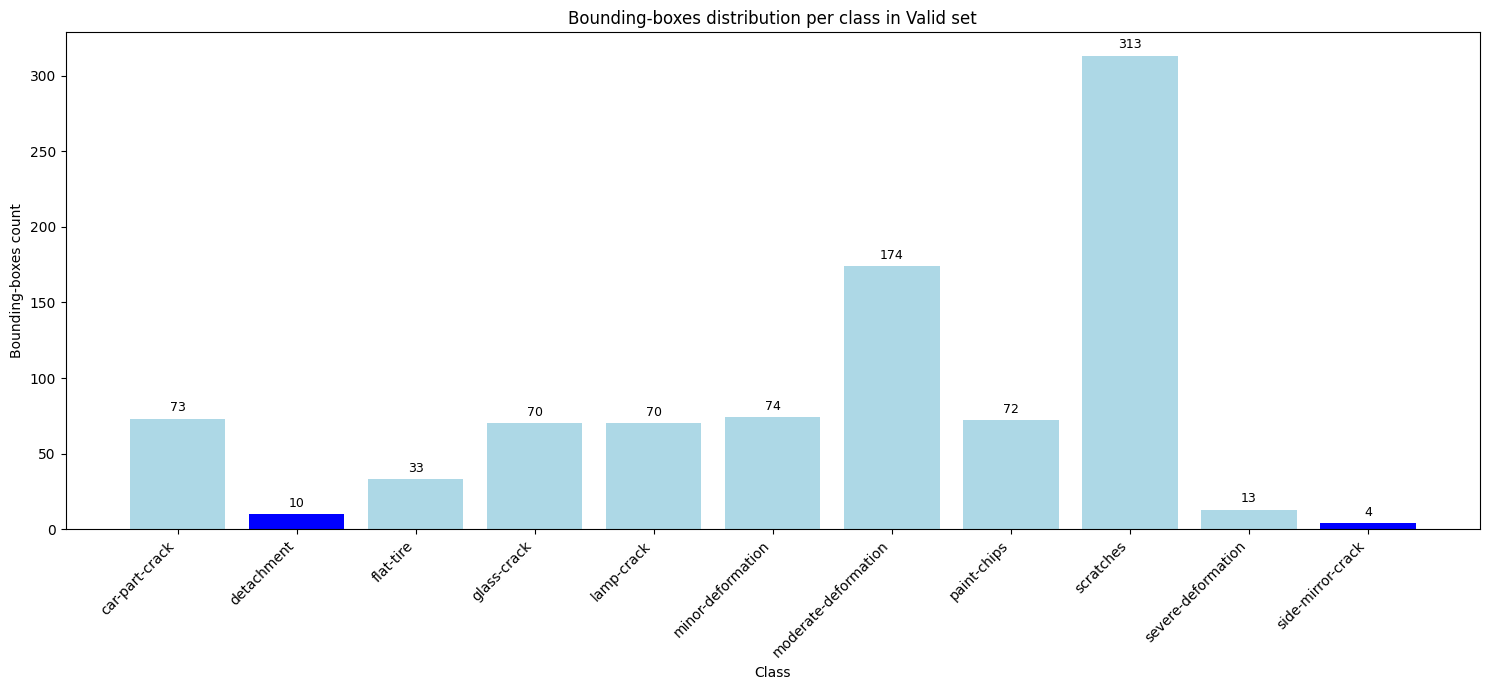

In [15]:
class_names = df_counts.columns.drop("split").tolist()
vals = df_counts.loc[df_counts["split"]=="valid", class_names].values.flatten()

x = np.arange(len(class_names))
plt.figure(figsize=(15, 7))

colors = ['blue' if v <= 10 else 'lightblue' for v in vals]
bars = plt.bar(x, vals, color=colors)

for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,  
        yval + 3,                          
        f"{int(yval)}",                  
        ha="center", va="bottom", fontsize=9
    )

plt.xlabel("Class")
plt.ylabel("Bounding-boxes count")
plt.title("Bounding-boxes distribution per class in Valid set")
plt.xticks(x, class_names, rotation=45, ha="right")
plt.tight_layout()
plt.show()

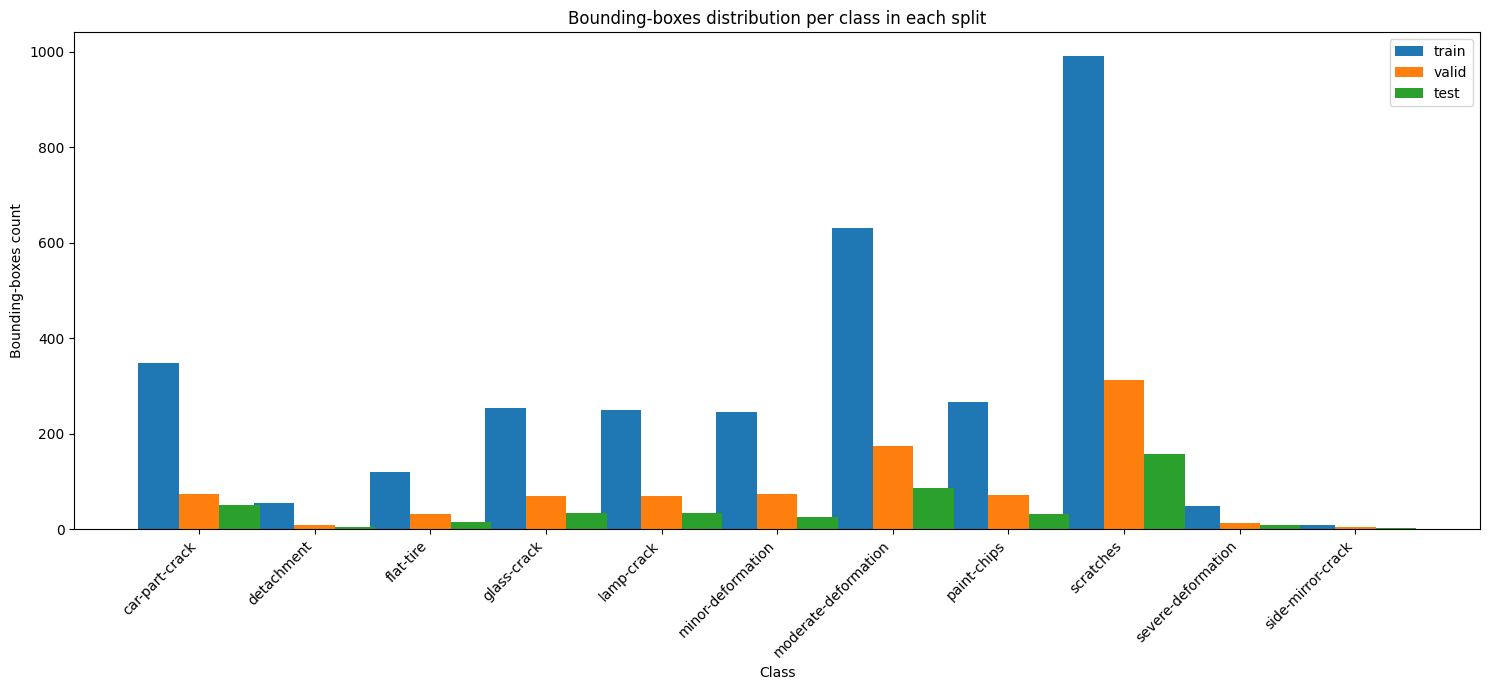

In [16]:
#ver todas as classes:
class_names = df_counts.columns.drop("split").tolist()
splits = df_counts["split"].tolist()
values = [ df_counts.loc[i, class_names].values for i in range(len(splits)) ]

x = np.arange(len(class_names))
width = 0.35

plt.figure(figsize=(15,7))
for i, (split, vals) in enumerate(zip(splits, values)):
    plt.bar(x + i*width, vals, width, label=split)

plt.xlabel("Class")
plt.ylabel("Bounding-boxes count")
plt.title("Bounding-boxes distribution per class in each split")
plt.xticks(x + width, class_names, rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

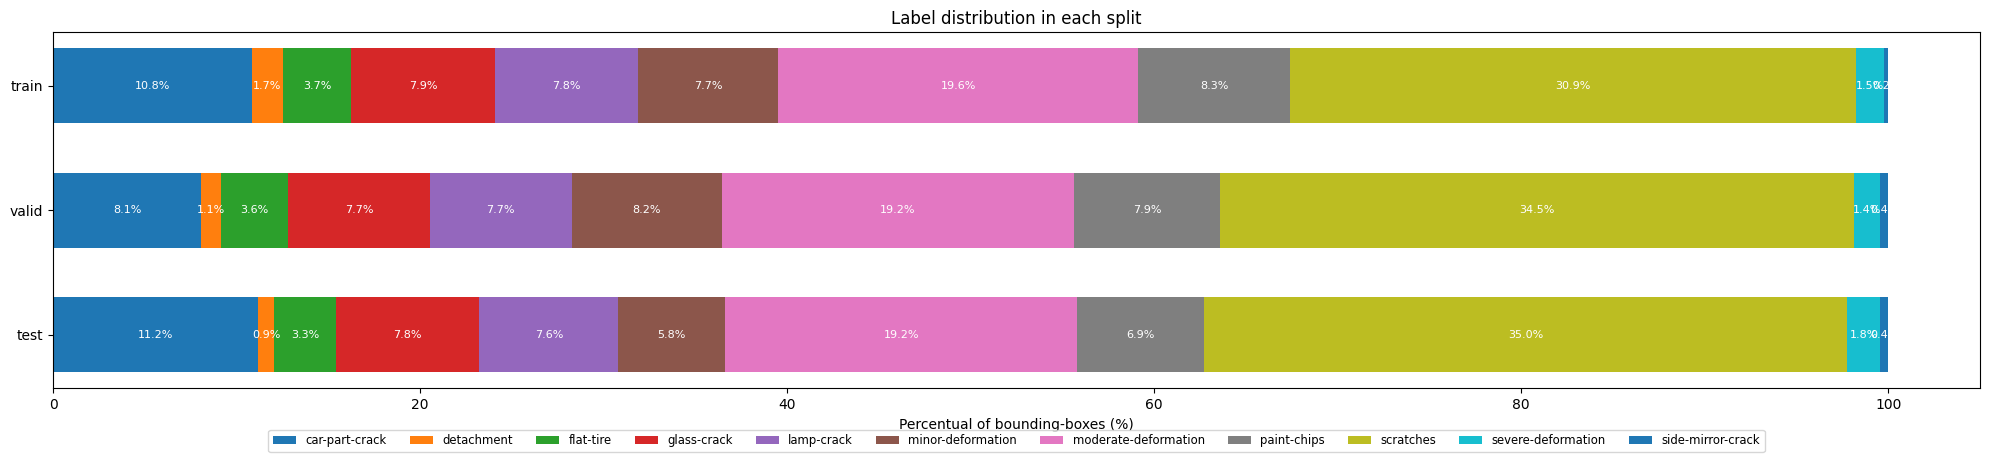

In [17]:
df_pct = df_counts.set_index("split")
df_pct = df_pct.div(df_pct.sum(axis=1), axis=0) * 100

splits  = df_pct.index.tolist() 
classes = df_pct.columns.tolist()
y = np.arange(len(splits))

fig, ax = plt.subplots(figsize=(20, 5))

left = np.zeros(len(splits))
for cls in classes:
    widths = df_pct[cls].values
    bars = ax.barh(y, widths, left=left, height=0.6, label=cls)
    for bar, w in zip(bars, widths):
        if w < 0.2:  # pula segmentos muito pequenos
            continue
        x_text = bar.get_x() + w/2
        y_text = bar.get_y() + bar.get_height()/2
        ax.text(
            x_text, y_text, f"{w:.1f}%",
            ha="center", va="center",
            color="white", fontsize=8
        )
    left += widths

ax.set_yticks(y)
ax.set_yticklabels(splits)
ax.set_xlabel("Percentual of bounding-boxes (%)")
ax.set_title("Label distribution in each split")
ax.invert_yaxis()

ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=11,
    fontsize="small"
)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

Como algumas classes mostram um desbalanceamento entre as classes, talvez seja melhor dar merge a algumas.

---
### Models:

#### Previous model - Prepair data:

In [18]:
#lista de labels para o train set:
records = []
for img in (BASE_path/"train"/"images").glob("*.jpg"):
    lbl = (BASE_path/"train"/"labels"/(img.stem + ".txt")).read_text().splitlines()
    if not lbl:
        continue
    cid = int(lbl[0].split()[0])
    records.append({"filepath": str(img), "label": class_names[cid]}) #nomes das labels
    #records.append({"filepath": str(img), "label": cid }) #label id (so o numero)

df_train = pd.DataFrame(records)
print(df_train)

                                               filepath                 label
0     Car-Damage-Severity-Detection\CarDD-3\train\im...             flat-tire
1     Car-Damage-Severity-Detection\CarDD-3\train\im...             flat-tire
2     Car-Damage-Severity-Detection\CarDD-3\train\im...             flat-tire
3     Car-Damage-Severity-Detection\CarDD-3\train\im...     minor-deformation
4     Car-Damage-Severity-Detection\CarDD-3\train\im...             flat-tire
...                                                 ...                   ...
1383  Car-Damage-Severity-Detection\CarDD-3\train\im...           glass-crack
1384  Car-Damage-Severity-Detection\CarDD-3\train\im...           glass-crack
1385  Car-Damage-Severity-Detection\CarDD-3\train\im...           glass-crack
1386  Car-Damage-Severity-Detection\CarDD-3\train\im...             scratches
1387  Car-Damage-Severity-Detection\CarDD-3\train\im...  moderate-deformation

[1388 rows x 2 columns]


In [19]:
#lista de labels para o valid set:
records = []
for img in (BASE_path/"valid"/"images").glob("*.jpg"):
    lbl = (BASE_path/"valid"/"labels"/(img.stem + ".txt")).read_text().splitlines()
    if not lbl:
        continue
    cid = int(lbl[0].split()[0])
    records.append({"filepath": str(img), "label": class_names[cid]}) #nomes das labels
    #records.append({"filepath": str(img), "label": cid }) #label id (so o numero)

df_valid = pd.DataFrame(records)
print(df_valid)

                                              filepath                 label
0    Car-Damage-Severity-Detection\CarDD-3\valid\im...           paint-chips
1    Car-Damage-Severity-Detection\CarDD-3\valid\im...             scratches
2    Car-Damage-Severity-Detection\CarDD-3\valid\im...             scratches
3    Car-Damage-Severity-Detection\CarDD-3\valid\im...     minor-deformation
4    Car-Damage-Severity-Detection\CarDD-3\valid\im...  moderate-deformation
..                                                 ...                   ...
396  Car-Damage-Severity-Detection\CarDD-3\valid\im...           glass-crack
397  Car-Damage-Severity-Detection\CarDD-3\valid\im...  moderate-deformation
398  Car-Damage-Severity-Detection\CarDD-3\valid\im...  moderate-deformation
399  Car-Damage-Severity-Detection\CarDD-3\valid\im...     minor-deformation
400  Car-Damage-Severity-Detection\CarDD-3\valid\im...    severe-deformation

[401 rows x 2 columns]


In [20]:

#map string para int
class_to_idx = { name: idx for idx, name in enumerate(class_names) }

df_train['label_id'] = df_train['label'].map(class_to_idx)
df_valid['label_id'] = df_valid['label'].map(class_to_idx)
df_valid['label_id']

0      7
1      8
2      8
3      5
4      6
      ..
396    3
397    6
398    6
399    5
400    9
Name: label_id, Length: 401, dtype: int64

In [21]:
#extrair arrays
filepaths = df_train['filepath'].to_numpy()
labels = df_train['label_id'].to_numpy().astype(np.int32)

filepaths_val = df_valid['filepath'].to_numpy()
labels_val = df_valid['label_id'].to_numpy().astype(np.int32)

img_height = 180
img_width  = 180
batch_size = 32

NUM_CLASSES = len(class_names)

def load_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_height, img_width]) / 255.0
    return img, label

ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))
ds_val = tf.data.Dataset.from_tensor_slices((filepaths_val, labels_val))

* `Dataset.cache` keeps the images in memory after they are loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model.
* `Dataset.prefetch` overlaps data preprocessing and model execution while training.

In [22]:
# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = (ds
    .shuffle(len(filepaths))
    .map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (ds_val
    .shuffle(len(filepaths_val))
    .map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

#### Previous model - Compile and Train the model

Train the model for 15, 50 and 100 epochs with the Keras `Model.fit` method:

In [23]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_height, 3)),
    layers.Conv2D(16, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(NUM_CLASSES, activation='softmax', name="outputs")
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    metrics=['accuracy']
)

model.summary()

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,990,059 (15.22 MB)

 Trainable params: 3,990,059 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

* 15 epochs

In [24]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - accuracy: 0.3030 - loss: 2.0190 - val_accuracy: 0.2943 - val_loss: 1.8318
Epoch 2/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.2965 - loss: 1.8084 - val_accuracy: 0.2943 - val_loss: 1.8222
Epoch 3/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.3217 - loss: 1.8012 - val_accuracy: 0.2943 - val_loss: 1.8196
Epoch 4/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.3123 - loss: 1.7987 - val_accuracy: 0.2943 - val_loss: 1.8182
Epoch 5/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.3120 - loss: 1.7987 - val_accuracy: 0.2943 - val_loss: 1.8193
Epoch 6/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.3252 - loss: 1.7975 - val_accuracy: 0.2943 - val_loss: 1.8177
Epoch 7/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.3202 - loss: 1.7953 - val_accuracy: 0.2943 - val_loss: 1.8160
Epoch 8/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.3325 - loss: 1.7922 - val_accuracy: 0.

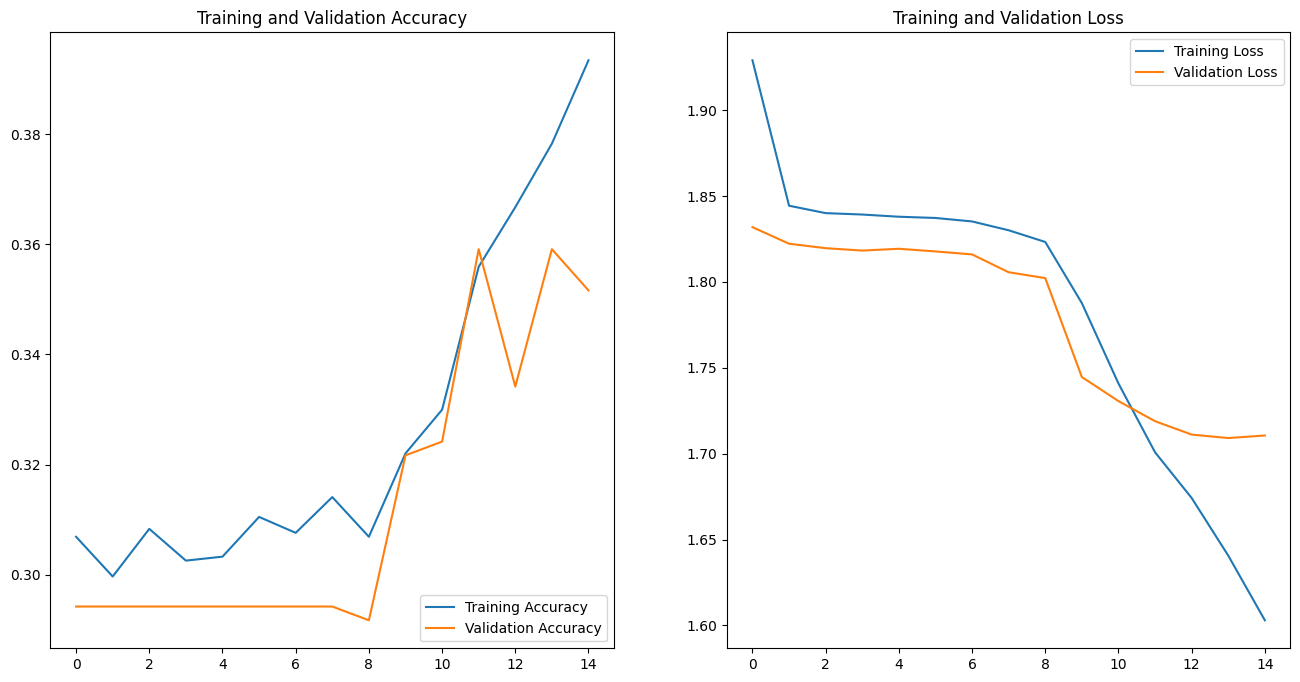

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

* 50 epochs

In [26]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_height, 3)),
    layers.Conv2D(16, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(NUM_CLASSES, activation='softmax', name="outputs")
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    metrics=['accuracy']
)

In [27]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 0.2490 - loss: 2.0692 - val_accuracy: 0.2943 - val_loss: 1.8229
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.3048 - loss: 1.8078 - val_accuracy: 0.2943 - val_loss: 1.8253
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.3064 - loss: 1.8055 - val_accuracy: 0.2943 - val_loss: 1.8228
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.3096 - loss: 1.8034 - val_accuracy: 0.2943 - val_loss: 1.8212
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.3325 - loss: 1.8017 - val_accuracy: 0.2943 - val_loss: 1.8205
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.3305 - loss: 1.8006 - val_accuracy: 0.2943 - val_loss: 1.8195
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 0.3325 - loss: 1.7988 - val_accuracy: 0.2943 - val_loss: 1.8141
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.3303 - loss: 1.7875 - val_accuracy: 0.

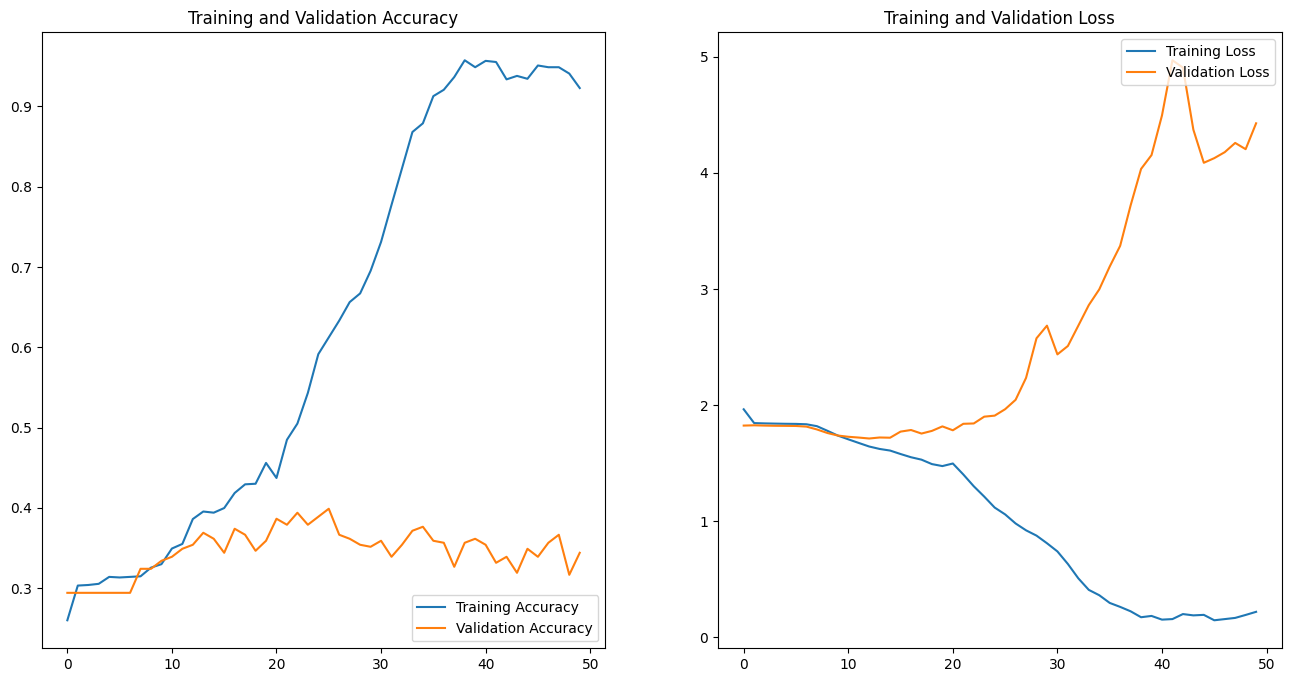

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

* 100 epochs:

In [29]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_height, 3)),
    layers.Conv2D(16, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(NUM_CLASSES, activation='softmax', name="outputs")
])
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    metrics=['accuracy']
)

In [30]:
epochs=100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.2628 - loss: 2.0428 - val_accuracy: 0.2943 - val_loss: 1.8257
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.3048 - loss: 1.8040 - val_accuracy: 0.2943 - val_loss: 1.8246
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 0.2985 - loss: 1.8017 - val_accuracy: 0.2943 - val_loss: 1.8225
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.3025 - loss: 1.7994 - val_accuracy: 0.2943 - val_loss: 1.8195
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.3066 - loss: 1.7963 - val_accuracy: 0.3117 - val_loss: 1.8141
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.3096 - loss: 1.7862 - val_accuracy: 0.2793 - val_loss: 1.8021
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.3318 - loss: 1.7485 - val_accuracy: 0.3441 - val_loss: 1.7535
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.3269 - loss: 1.7179 - val_accu

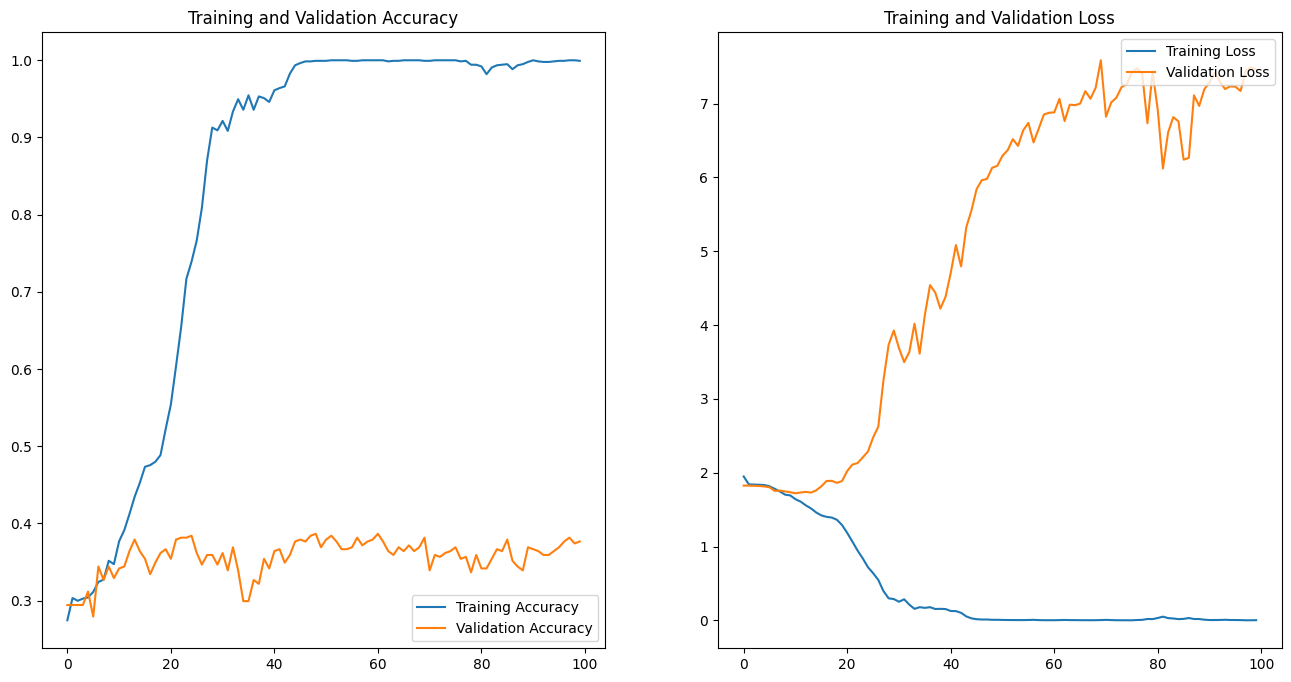

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

---
#### New model - Prepair data

##### Convert labels to csv

Converter ficheiros .txt em vector multi-label: \
ResNet só precisa de saber “esta imagem contém classe 0, 5 e 8”.

Le cada .txt, recolhe os class_id distintos e guarda num CSV.

Multi-hot (0/1) serve quando queres apenas “esta classe aparece ou não”.
Mas, para uma estimativa de custo, o número de instâncias por classe
(2 arranhões vs 1) :


*   Colunas h0…h10 → hot (0/1) — bom para o classificador.

* Colunas n0…n10 → counts — podes usar como features extra no regress
LightGBM (ou outro modelo de custo).



In [32]:
with open("./Car-Damage-Severity-Detection/CarDD-3/data.yaml") as f:
    CLASSES = yaml.safe_load(f)["names"]
NUM_CLASSES = len(CLASSES)

print(NUM_CLASSES, CLASSES)

11 ['car-part-crack', 'detachment', 'flat-tire', 'glass-crack', 'lamp-crack', 'minor-deformation', 'moderate-deformation', 'paint-chips', 'scratches', 'severe-deformation', 'side-mirror-crack']


In [33]:
def labels_to_counts(label_path: str, num_classes: int):
    counts = [0] * num_classes
    with open(label_path) as f:
        for line in f:
            cid = int(line.split()[0])
            counts[cid] += 1
    return counts

def build_csv(split: str):
    IMG_DIR   = f"./Car-Damage-Severity-Detection/CarDD-3/{split}/images"
    LABEL_DIR = f"./Car-Damage-Severity-Detection/CarDD-3/{split}/labels"

    rows = []
    for lp in glob.glob(f"{LABEL_DIR}/*.txt"):
        img_name = os.path.basename(lp).replace(".txt", ".jpg")  # muda p/ .png se for o caso
        counts   = labels_to_counts(lp, NUM_CLASSES)
        hot      = [1 if n > 0 else 0 for n in counts]

        row = {"image": f"{IMG_DIR}/{img_name}"}
        row.update({f"h{i}": v for i, v in enumerate(hot)})    # presença
        row.update({f"n{i}": v for i, v in enumerate(counts)}) # nº instâncias
        rows.append(row)

    df = pd.DataFrame(rows)
    csv_out = f"{split}_multilabel.csv"
    df.to_csv(csv_out, index=False)
    print(f"Gravado {csv_out} com {len(df)} linhas")
    return df.head()

In [34]:
for split in ["train", "valid", "test"]:
    head = build_csv(split)
    if split == "train":
        print("\nPreview do train\n", head)

Gravado train_multilabel.csv com 1395 linhas

Preview do train
                                                image  h0  h1  h2  h3  h4  h5  \
0  ./Car-Damage-Severity-Detection/CarDD-3/train/...   1   0   1   0   0   0   
1  ./Car-Damage-Severity-Detection/CarDD-3/train/...   0   0   1   0   0   0   
2  ./Car-Damage-Severity-Detection/CarDD-3/train/...   0   0   1   0   0   0   
3  ./Car-Damage-Severity-Detection/CarDD-3/train/...   0   0   1   0   0   1   
4  ./Car-Damage-Severity-Detection/CarDD-3/train/...   0   0   1   0   0   0   

   h6  h7  h8  ...  n1  n2  n3  n4  n5  n6  n7  n8  n9  n10  
0   0   0   0  ...   0   1   0   0   0   0   0   0   0    0  
1   0   0   0  ...   0   1   0   0   0   0   0   0   0    0  
2   0   0   0  ...   0   1   0   0   0   0   0   0   0    0  
3   0   0   1  ...   0   2   0   0   1   0   0   1   0    0  
4   1   1   0  ...   0   1   0   0   0   1   1   0   0    0  

[5 rows x 23 columns]
Gravado valid_multilabel.csv com 401 linhas
Gravado test_mul

---
##### Transformations


transformações: \
- Augmentations - Aumentar a variedade do treino (menos over-fit) e
- redimensionamento - deixa as imagens no formato que a ResNet espera (640×640)

para para **imagens train set**
1. RandomResizedCrop – recorta 80-100 % da imagem e redimensiona para 640×640 → simula zooms/enquadramentos diferentes.
2. HorizontalFlip – espelha metade das vezes → dobra o dataset virtualmente.
3. Rotate (±15°) – tolera fotos um pouco inclinadas.
4. RandomBrightnessContrast – variação de luz.
5. GaussNoise – ruído de câmara/compressão.
6. Normalize – converte 0-255→ (float32) e aplica média/STD do ImageNet (necessário para redes pré-treinadas).
7. ToTensorV2 – converte numpy → tensor PyTorch C×H×W.-

E para **imagens valid set** apenas redimensiona para 640×640, normaliza e converte em tensor. Mantemos as imagens “puras” para medir o desempenho real.

In [35]:
with open("./Car-Damage-Severity-Detection/CarDD-3/data.yaml") as f:
    class_names = yaml.safe_load(f)["names"]
NUM_CLASSES = len(class_names)

IMG_SIZE = 640

In [36]:
#augmentation às imagens de treino:
train_tfms = A.Compose([
    A.RandomResizedCrop(size=(IMG_SIZE, IMG_SIZE), scale=(0.8, 1.0), ratio=(3/4,4/3), p=1.0),
    #A.RandomResizedCrop(height=IMG_SIZE, width=IMG_SIZE, scale=(0.8, 1.0), p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.GaussNoise(p=0.2),
    A.Normalize(),
    ToTensorV2()
])

#e para valid set:
val_tfms = A.Compose([
    A.Resize(height=IMG_SIZE, width=IMG_SIZE),
    A.Normalize(),
    ToTensorV2()
])

---

#### New model - implement

pip install ultralytics


!yolo detect train \
  model=yolov8s.pt \
  data=Car-Damage-Severity-Detection/CarDD-3/data.yaml \
  epochs=50 \
  imgsz=640 \
  batch=16
For YOLOv8: yolo detect train \
data=data.yaml \
model=yolov8n.pt \
imgsz=640 \
epochs=50 \
lr0=0.01 \
frozen=10.

!yolo detect train \
  data=./Car-Damage-Severity-Detection/CarDD-3/data.yaml \
  model=yolov8s.pt \
  epochs=30 \
  project=runs/train \
  name=car_damage_v1

In [43]:
%pip install -q ultralytics

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from ultralytics import YOLO
model = YOLO('yolov8s.pt')
model.train(
    data='./Car-Damage-Severity-Detection/CarDD-3/data.yaml',
    epochs=50,
    imgsz=640,
    batch=16,
    project='runs/train',
    name='car_damage_v1'
)

Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\Alexandre\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 21.5M/21.5M [00:05<00:00, 3.91MB/s]


Ultralytics 8.3.145  Python-3.12.2 torch-2.7.0+cpu CPU (AMD Ryzen 5 3600 6-Core Processor)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./Car-Damage-Severity-Detection/CarDD-3/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=car_damage_v1, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.

100%|██████████| 755k/755k [00:00<00:00, 2.47MB/s]

Overriding model.yaml nc=80 with nc=11

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytic

 15                  -1  1    148224  ultralytics.nn.modules.block.C2f             [384, 128, 1]                 
 16                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
 17            [-1, 12]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 18                  -1  1    493056  ultralytics.nn.modules.block.C2f             [384, 256, 1]                 
 19                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
 20             [-1, 9]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 21                  -1  1   1969152  ultralytics.nn.modules.block.C2f             [768, 512, 1]                 
 22        [15, 18, 21]  1   2120305  ultralytics.nn.modules.head.Detect           [11, [128, 256, 512]]         
Model summary: 129 layers, 11,139,857 parameters, 11,139,841 gradients, 28.7 GFLOPs

Tra

train: Scanning C:\Users\Alexandre\Documents\Visual_Studio_Code\DL\3 - Projeto_final\Car-Damage-Severity-Detection\CarDD-3\train\labels... 1395 images, 7 backgrounds, 0 corrupt: 100%|██████████| 1395/1395 [00:01<00:00, 1160.31it/s]


train: New cache created: C:\Users\Alexandre\Documents\Visual_Studio_Code\DL\3 - Projeto_final\Car-Damage-Severity-Detection\CarDD-3\train\labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access  (ping: 0.20.1 ms, read: 164.759.1 MB/s, size: 84.5 KB)


'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
val: Scanning C:\Users\Alexandre\Documents\Visual_Studio_Code\DL\3 - Projeto_final\Car-Damage-Severity-Detection\CarDD-3\valid\labels... 401 images, 0 backgrounds, 0 corrupt: 100%|██████████| 401/401 [00:00<00:00, 1712.11it/s]

val: New cache created: C:\Users\Alexandre\Documents\Visual_Studio_Code\DL\3 - Projeto_final\Car-Damage-Severity-Detection\CarDD-3\valid\labels.cache



'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.


Plotting labels to runs\train\car_damage_v1\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\train\car_damage_v1
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G       1.43      3.558      1.588         12        640: 100%|██████████| 88/88 [14:22<00:00,  9.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [01:12<00:00,  5.60s/it]

                   all        401        906      0.509      0.232      0.212      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.345      2.391      1.497         12        640: 100%|██████████| 88/88 [14:19<00:00,  9.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [01:08<00:00,  5.28s/it]

                   all        401        906       0.52      0.263      0.249      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G       1.39       2.32       1.53         19        640: 100%|██████████| 88/88 [14:14<00:00,  9.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [01:04<00:00,  4.94s/it]

                   all        401        906      0.413      0.259      0.232      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      1.392      2.224      1.542         17        640: 100%|██████████| 88/88 [13:22<00:00,  9.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [01:04<00:00,  4.96s/it]

                   all        401        906       0.49       0.27      0.239      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      1.363      2.169      1.506         29        640: 100%|██████████| 88/88 [25:24<00:00, 17.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [02:05<00:00,  9.69s/it]

                   all        401        906      0.516      0.285      0.276      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      1.311      2.052      1.469         91        640:  12%|█▎        | 11/88 [03:46<25:45, 20.07s/it]

---


#### Data imbalance:


As classes que tinham poucos samples eram a "detachment" e "side-miror-crack", podemos ver uns exemplos:

In [41]:
with open("./Car-Damage-Severity-Detection/CarDD-3/data.yaml") as f:
    data = yaml.safe_load(f)
class_names = data["names"]
target_class = "side-mirror-crack"
#target_class = "detachment"
target_cid   = class_names.index(target_class)

split   = "train"
img_dir = f"./Car-Damage-Severity-Detection/CarDD-3/{split}/images"
lbl_dir = f"./Car-Damage-Severity-Detection/CarDD-3/{split}/labels"

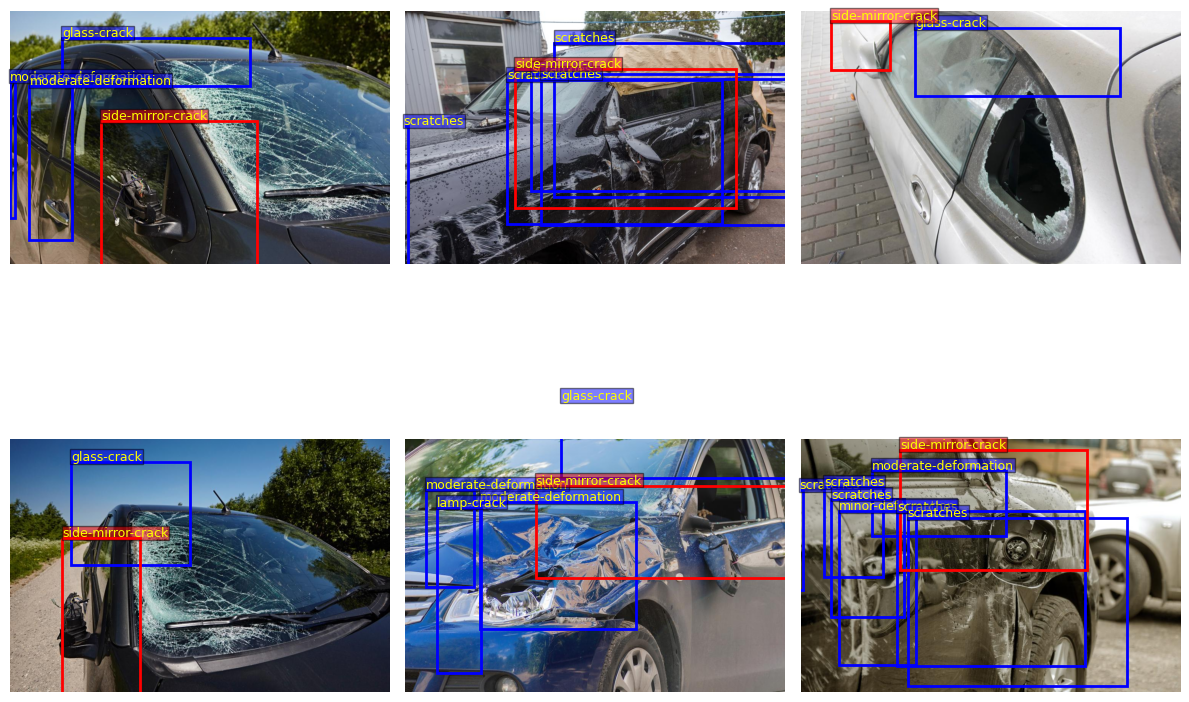

In [42]:
all_imgs = [f for f in os.listdir(img_dir) if f.lower().endswith(".jpg")]
det_imgs = []
for img_name in all_imgs:
    lbl_path = os.path.join(lbl_dir, img_name.replace(".jpg", ".txt"))
    with open(lbl_path) as f_lbl:
        for line in f_lbl:
            cid = int(line.split()[0])
            if cid == target_cid:
                det_imgs.append(img_name)
                break

sample = random.sample(det_imgs, min(len(det_imgs), 6))

fig = plt.figure(figsize=(12, 10))
for i, fname in enumerate(sample, 1):
    img = Image.open(os.path.join(img_dir, fname))
    w, h = img.size
    boxes = []
    with open(os.path.join(lbl_dir, fname.replace(".jpg", ".txt"))) as f_lbl:
        for line in f_lbl:
            parts = line.split()
            cid = int(parts[0])
            x_c, y_c, bw, bh = map(float, parts[1:5])
            x1 = (x_c - bw/2) * w
            y1 = (y_c - bh/2) * h
            boxes.append((cid, x1, y1, bw * w, bh * h))

    ax = fig.add_subplot(2, 3, i)
    ax.imshow(img)
    ax.axis("off")

    for cid, x1, y1, bw_px, bh_px in boxes:
        color = "red" if cid == target_cid else "blue"
        rect = patches.Rectangle((x1, y1), bw_px, bh_px,
                                 linewidth=2, edgecolor=color, facecolor="none")
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, class_names[cid],
                fontsize=9, color="yellow",
                bbox=dict(facecolor=color, alpha=0.5, pad=0.5))

plt.tight_layout()
plt.show()

In [ ]:
orig_yaml = BASE_path/"data.yaml"
merged_yaml = BASE_path/"data_merged.yaml"

with open(orig_yaml) as f:
    data = yaml.safe_load(f)
orig_names = data["names"]

merge_map = {
    "side-mirror-crack" : "car-part-crack",
    "detachment"  : "severe-deformation",
}

new_names = []
for name in orig_names:
    target = merge_map.get(name, name)
    if target not in new_names:
        new_names.append(target)

old2new = { old_i: new_names.index( merge_map.get(old_name, old_name) )
            for old_i, old_name in enumerate(orig_names) }

data["names"] = new_names
data["nc"]    = len(new_names)
# ajusta os paths:
data["train"] = str(Path(data["train"]).parent / "train/images")
data["val"]   = str(Path(data["val"]).parent   / "valid/images")
data["test"]  = str(Path(data["test"]).parent  / "test/images")

with open(merged_yaml, "w") as f:
    yaml.dump(data, f, sort_keys=False)
print(f"{merged_yaml} com classes: {new_names}")

In [ ]:
for split in ["train", "valid", "test"]:
    src_lbl_dir = BASE_path/split/"labels"
    dst_lbl_dir = BASE_path/"labels_merged"/split
    dst_lbl_dir.mkdir(parents=True, exist_ok=True)

    for txt in sorted((src_lbl_dir).glob("*.txt")):
        lines = txt.read_text().splitlines()
        new_lines = []
        for line in lines:
            parts = line.split()
            if len(parts) < 5:
                continue
            old_id = int(parts[0])
            coords = parts[1:]
            new_id = old2new.get(old_id)
            if new_id is None:
                continue
            new_lines.append(" ".join([str(new_id)] + coords))
        (dst_lbl_dir/ txt.name).write_text("\n".join(new_lines))

    print(f"  • {split:5s}: reescritos {len(list(dst_lbl_dir.glob('*.txt')))} labels em labels_merged/{split}")


Para ver como ficou o merged, perceber a distribuiçao dos labels:

In [48]:
with open(BASE_path / "data_merged.yaml") as f:
    class_names = yaml.safe_load(f)["names"]

rows = []
for split in ["train", "valid", "test"]:
    counts = {name: 0 for name in class_names}
    for lbl_file in (BASE_path /"labels_merged"/ split).glob("*.txt"):
        for line in open(lbl_file):
            parts = line.split()
            if parts:
                cid = int(parts[0])
                counts[class_names[cid]] += 1
    rows.append({"split": split, **counts})

df_counts = pd.DataFrame(rows)
df_counts

split  car-part-crack  severe-deformation  flat-tire  glass-crack  \
0  train             356                 102        119          253   
1  valid              77                  23         33           70   
2   test              52                  12         15           35   

   lamp-crack  minor-deformation  moderate-deformation  paint-chips  scratches  
0         249                246                   630          266        991  
1          70                 74                   174           72        313  
2          34                 26                    86           31        157

In [64]:
with open('./Car-Damage-Severity-Detection/CarDD-3/data_merged.yaml') as f:
    data = yaml.safe_load(f)

print("Nomes de classe (ID --> nome):")
for idx, name in enumerate(data['names']):
    print(idx, name)

Nomes de classe (ID --> nome):
0 car-part-crack
1 severe-deformation
2 flat-tire
3 glass-crack
4 lamp-crack
5 minor-deformation
6 moderate-deformation
7 paint-chips
8 scratches


#### Re-try model:

In [49]:
#lista de labels para o train set:
records = []
for img in (BASE_path/"train"/"images").glob("*.jpg"):
    lbl = (BASE_path/"labels_merged"/"train"/(img.stem + ".txt")).read_text().splitlines()
    if not lbl:
        continue
    cid = int(lbl[0].split()[0])
    records.append({"filepath": str(img), "label": class_names[cid]}) 
df_train = pd.DataFrame(records)

df_train

filepath                 label
0     Car-Damage-Severity-Detection\CarDD-3\train\im...             flat-tire
1     Car-Damage-Severity-Detection\CarDD-3\train\im...             flat-tire
2     Car-Damage-Severity-Detection\CarDD-3\train\im...             flat-tire
3     Car-Damage-Severity-Detection\CarDD-3\train\im...     minor-deformation
4     Car-Damage-Severity-Detection\CarDD-3\train\im...             flat-tire
...                                                 ...                   ...
1383  Car-Damage-Severity-Detection\CarDD-3\train\im...           glass-crack
1384  Car-Damage-Severity-Detection\CarDD-3\train\im...           glass-crack
1385  Car-Damage-Severity-Detection\CarDD-3\train\im...           glass-crack
1386  Car-Damage-Severity-Detection\CarDD-3\train\im...             scratches
1387  Car-Damage-Severity-Detection\CarDD-3\train\im...  moderate-deformation

[1388 rows x 2 columns]

In [55]:
#lista de labels para o valid set:
records = []
for img in (BASE_path/"valid"/"images").glob("*.jpg"):
    lbl = (BASE_path/"labels_merged"/"valid"/(img.stem + ".txt")).read_text().splitlines()
    if not lbl:
        continue
    cid = int(lbl[0].split()[0])
    records.append({"filepath": str(img), "label": class_names[cid]}) #nomes das labels
    #records.append({"filepath": str(img), "label": cid }) #label id (so o numero)
df_valid = pd.DataFrame(records)
df_valid

filepath                 label
0    Car-Damage-Severity-Detection\CarDD-3\valid\im...           paint-chips
1    Car-Damage-Severity-Detection\CarDD-3\valid\im...             scratches
2    Car-Damage-Severity-Detection\CarDD-3\valid\im...             scratches
3    Car-Damage-Severity-Detection\CarDD-3\valid\im...     minor-deformation
4    Car-Damage-Severity-Detection\CarDD-3\valid\im...  moderate-deformation
..                                                 ...                   ...
396  Car-Damage-Severity-Detection\CarDD-3\valid\im...           glass-crack
397  Car-Damage-Severity-Detection\CarDD-3\valid\im...  moderate-deformation
398  Car-Damage-Severity-Detection\CarDD-3\valid\im...  moderate-deformation
399  Car-Damage-Severity-Detection\CarDD-3\valid\im...     minor-deformation
400  Car-Damage-Severity-Detection\CarDD-3\valid\im...    severe-deformation

[401 rows x 2 columns]

In [ ]:
#map string para int
class_to_idx = { name: idx for idx, name in enumerate(class_names) }

df_train['label_id'] = df_train['label'].map(class_to_idx)
df_valid['label_id'] = df_valid['label'].map(class_to_idx)

#extrair arrays
filepaths = df_train['filepath'].to_numpy()
labels = df_train['label_id'].to_numpy().astype(np.int32)

filepaths_val = df_valid['filepath'].to_numpy()
labels_val = df_valid['label_id'].to_numpy().astype(np.int32)

img_height = 180
img_width  = 180
batch_size = 32

NUM_CLASSES = len(class_names)
NUM_CLASSES

9

In [58]:
def load_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_height, img_width]) / 255.0
    return img, label

ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))
ds_val = tf.data.Dataset.from_tensor_slices((filepaths_val, labels_val))
# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = (ds
    .shuffle(len(filepaths))
    .map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (ds_val
    .shuffle(len(filepaths_val))
    .map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

In [59]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_height, 3)),
    layers.Conv2D(16, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(NUM_CLASSES, activation='softmax', name="outputs")
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    metrics=['accuracy']
)

model.summary()

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.2481 - loss: 1.9526 - val_accuracy: 0.2943 - val_loss: 1.8322
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.3133 - loss: 1.8289 - val_accuracy: 0.2943 - val_loss: 1.8257
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.3133 - loss: 1.8251 - val_accuracy: 0.2943 - val_loss: 1.8244
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.3133 - loss: 1.8232 - val_accuracy: 0.2943 - val_loss: 1.8222
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.3133 - loss: 1.8159 - val_accuracy: 0.2943 - val_loss: 1.7973
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.3095 - loss: 1.7908 - val_accuracy: 0.2893 - val_loss: 1.7861
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.3248 - loss: 1.7436 - val_accuracy: 0.3067 - val_loss: 1.7566
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.3272 - loss: 1.7134 - val_accuracy: 0.3317 - 

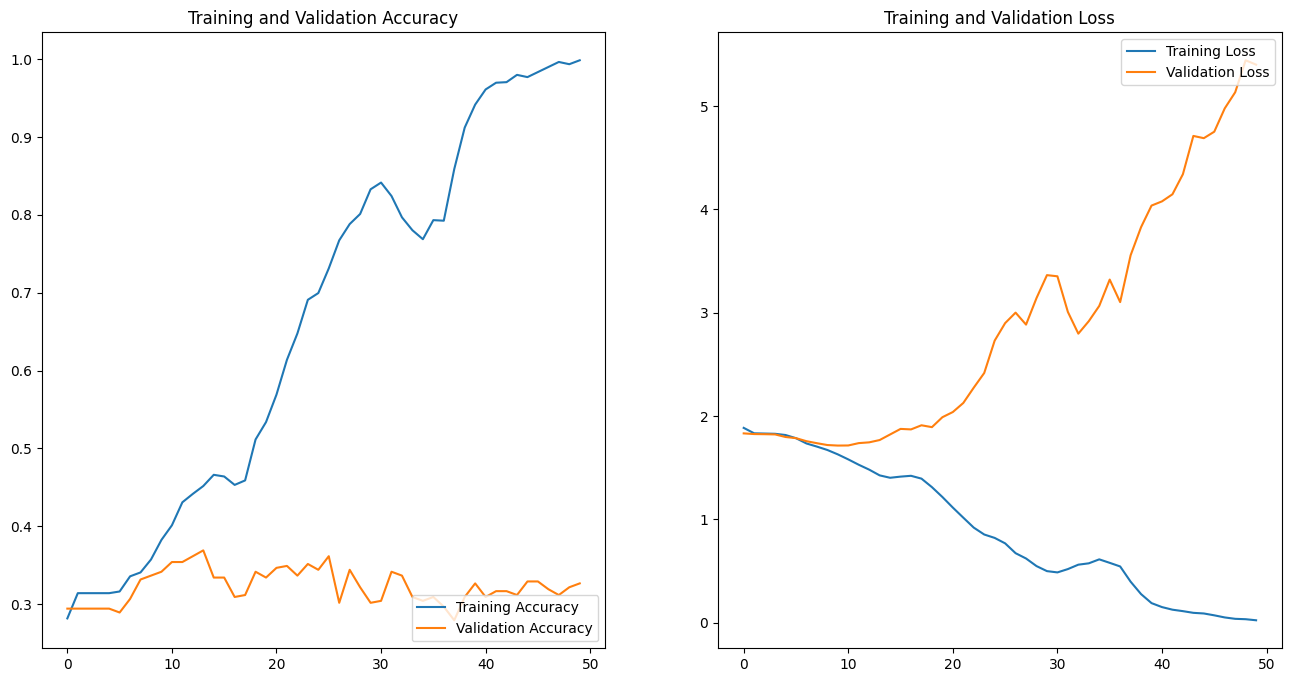

In [61]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()